# Comparison of predictive features between the single- and multi-center RPN signature
- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/2_feature_analysis.ipynb
- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature
- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3
- Raw data from center 3 is available upon reasonable request.

## Imports

In [46]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

## Load behavioral data

In [47]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

## Load the saved final multi-center model

In [48]:
# load the RPN-signature (trained on sample 1):
model_multi_center = joblib.load('../res/multi-center/finalized_model_multi-center.joblib') 
model_multi_center_combat = joblib.load('../res/multi-center/finalized_model_combat_multi-center.joblib') 

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator SelectKBest from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator ElasticNet from version 0.23.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.1 when u

### function to extract predictive weights

In [49]:
#get region names from an arbitrary timeseries file
ts = pd.read_csv('../data/bochum-sample/regional_timeseries/bochum-023_pumi-17-scrubbed.tsv').iloc[:,1:] 
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")

# function to extract predictive weights:
def get_weights(model, labels=labels, modules=modules):
    RES = np.zeros(int(len(labels)*(len(labels)-1)/2))

    featuremask = model.named_steps['fsel'].get_support()
    RES[featuremask] = model.named_steps['model'].coef_
    
    print(np.sum(model.named_steps['model'].coef_!=0))
    
    RES_MAT = vec_to_sym_matrix(RES, diagonal=np.repeat(0, len(labels)))
    print(np.sum(RES_MAT!=0))
    return RES_MAT
    

### plot the predictive network

85
170


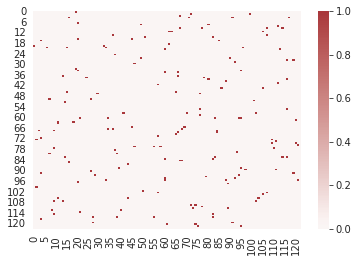

31
62


<AxesSubplot:>

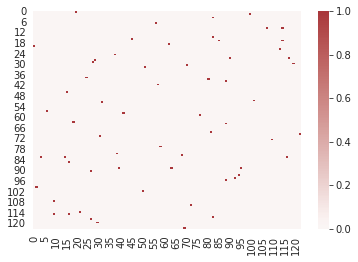

In [50]:
sns.heatmap(get_weights(model_multi_center)!=0, cmap="vlag", center=0)
plt.show()
sns.heatmap(get_weights(model_multi_center_combat)!=0, cmap="vlag", center=0)

## Load the weights of the RPN-siganture

In [51]:
rpn_conns = pd.read_csv("../res/predictive_connections.csv")
rpn_conns['abs_weight'] = rpn_conns['weight'].abs()
rpn_conns = rpn_conns.sort_values('abs_weight', ascending=False)
rpn_conns = rpn_conns.reset_index()
rpn_conns

,index,Unnamed: 0,idx_A,idx_B,mod_A,mod_B,reg_A,reg_B,weight,abs_weight
0,15,15,88,95,3_VATTnet_SALnet_BG_THAL,3_VATTnet_SALnet_BG_THAL,PUT_p,STgyr_p,0.270232,0.270232
1,5,5,15,45,1_CER,5_FPnet_VISDN,CER5,FP,0.245274,0.245274
2,1,1,1,99,1_CER,3_VATTnet_SALnet_BG_THAL,CER6_p,PSMcor_p,-0.200617,0.200617
3,7,7,16,85,1_CER,6_MOTnet,R_CERCR2_a,MOTnet_l,0.149634,0.149634
4,14,14,82,114,6_MOTnet,8_VISnet,MOTnet_m,MVISnet_p,-0.102468,0.102468
5,20,20,121,122,8_VISnet,8_VISnet,LVISnet_DP,VVISnet_m,0.094911,0.094911
6,0,0,0,34,2_MEAN_GM,7_DMnet,aMEAN_GM,L_IPlob,-0.086423,0.086423
7,18,18,96,116,3_VATTnet_SALnet_BG_THAL,8_VISnet,CAUDN_v,LVISnet_p,0.085078,0.085078
8,12,12,67,118,4_LIMnet,8_VISnet,CAUDNH_NACC,PVISnet_vm,-0.072571,0.072571
9,13,13,68,84,4_LIMnet,6_MOTnet,COLsul,MOTnet_vl,-0.062491,0.062491


## Create table for the multi center model without combat

In [52]:
#create a similar table from the multi-center signsature
RES_MAT = get_weights(model_multi_center)

df = pd.DataFrame(RES_MAT, columns=labels, index=labels)

idx = np.transpose(np.nonzero(np.triu(RES_MAT, k=1)))
print("Number of predictive connections:" + str(len(idx)))

lab = labels
#mod = modules
# hack for visulaization order
mod = np.array(['2_MEAN_GM',
'1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER',
 '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '1_CER', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet', '7_DMnet',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN',
 '5_FPnet_VISDN', '5_FPnet_VISDN', '5_FPnet_VISDN', '4_LIMnet', '4_LIMnet', '4_LIMnet',
 '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet', '4_LIMnet',
 '4_LIMnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet', '6_MOTnet',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL',
 '3_VATTnet_SALnet_BG_THAL', '3_VATTnet_SALnet_BG_THAL', '8_VISnet', '8_VISnet',
 '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet', '8_VISnet',
 '8_VISnet', '8_VISnet', '8_VISnet'])

#hack: rename for visualization order

multi_center_conns = pd.DataFrame( {'idx_A': idx[:,0],
                   'reg_A': lab[np.array(idx[:,0])],
                   'mod_A': mod[np.array(idx[:,0])],
                   'idx_B': idx[:,1],
                   'reg_B': lab[np.array(idx[:,1])],
                   'mod_B': mod[np.array(idx[:,1])],
                   'multi-center': RES_MAT[np.nonzero(np.triu(RES_MAT, k=1))].flatten()})


#table.to_csv(global_vars._RES_PRED_CONN_)
multi_center_conns['abs_multi-center'] = multi_center_conns['multi-center'].abs()
#table = table.sort_values('abs_multi-center', ascending=False)
#table = table.reset_index()
multi_center_conns

85
170
Number of predictive connections:85


,idx_A,reg_A,mod_A,idx_B,reg_B,mod_B,multi-center,abs_multi-center
0,0,GlobSig,2_MEAN_GM,19,VMPFcor_p,7_DMnet,0.072555,0.072555
1,1,CER6_p,1_CER,72,MORBgyr,4_LIMnet,0.004827,0.004827
2,1,CER6_p,1_CER,99,PSMcor_p,3_VATTnet_SALnet_BG_THAL,-0.082088,0.082088
3,2,CER7ab,1_CER,67,CAUDNH_NACC,4_LIMnet,0.034224,0.034224
4,3,R_CERCR2_p,1_CER,16,R_CERCR2_a,1_CER,0.022155,0.022155
5,3,R_CERCR2_p,1_CER,71,STgyr_a,4_LIMnet,-0.051295,0.051295
6,3,R_CERCR2_p,1_CER,91,AINS_v,3_VATTnet_SALnet_BG_THAL,-0.011106,0.011106
7,3,R_CERCR2_p,1_CER,117,PVISnet_dm,8_VISnet,0.001050,0.001050
8,6,L_CERCR2_a,1_CER,20,R_MTgyr_a,7_DMnet,-0.026498,0.026498
9,7,CER9_d,1_CER,49,L_MFgyr_pc,5_FPnet_VISDN,0.000849,0.000849


## Create table for the multi center model with combat

In [53]:
#create a similar table from the multi-center signsature
RES_MAT = get_weights(model_multi_center_combat)

df = pd.DataFrame(RES_MAT, columns=labels, index=labels)

idx = np.transpose(np.nonzero(np.triu(RES_MAT, k=1)))
print("Number of predictive connections:" + str(len(idx)))



multi_center_conns_combat = pd.DataFrame( {'idx_A': idx[:,0],
                   'reg_A': lab[np.array(idx[:,0])],
                   'mod_A': mod[np.array(idx[:,0])],
                   'idx_B': idx[:,1],
                   'reg_B': lab[np.array(idx[:,1])],
                   'mod_B': mod[np.array(idx[:,1])],
                   'multi-center_combat': RES_MAT[np.nonzero(np.triu(RES_MAT, k=1))].flatten()})


#table.to_csv(global_vars._RES_PRED_CONN_)
multi_center_conns_combat['abs_multi-center_combat'] = multi_center_conns_combat['multi-center_combat'].abs()
#table = table.sort_values('abs_multi-center', ascending=False)
#table = table.reset_index()
multi_center_conns_combat

31
62
Number of predictive connections:31


,idx_A,reg_A,mod_A,idx_B,reg_B,mod_B,multi-center_combat,abs_multi-center_combat
0,0,GlobSig,2_MEAN_GM,19,VMPFcor_p,7_DMnet,0.104911,0.104911
1,1,CER6_p,1_CER,99,PSMcor_p,3_VATTnet_SALnet_BG_THAL,-0.080330,0.080330
2,3,R_CERCR2_p,1_CER,82,MOTnet_m,6_MOTnet,-0.027575,0.027575
3,6,L_CERCR2_a,1_CER,56,L_IFsul,5_FPnet_VISDN,-0.039034,0.039034
4,9,CER7b_m,1_CER,107,PCcor.1,3_VATTnet_SALnet_BG_THAL,0.040663,0.040663
5,9,CER7b_m,1_CER,114,MVISnet_p,8_VISnet,0.071035,0.071035
6,14,CER6_d,1_CER,82,MOTnet_m,6_MOTnet,-0.064479,0.064479
7,15,CER5,1_CER,45,FP,5_FPnet_VISDN,0.103640,0.103640
8,16,R_CERCR2_a,1_CER,85,MOTnet_l,6_MOTnet,0.104155,0.104155
9,16,R_CERCR2_a,1_CER,114,MVISnet_p,8_VISnet,-0.114222,0.114222


### some table transformations

In [54]:
rpn_conns['single-center']=rpn_conns['weight']
rpn_conns['connectivity'] = rpn_conns.reg_A.str.cat(' - ' + rpn_conns.reg_B).values
#rpn_conns = rpn_conns.set_index('connectivity', drop=)


multi_center_conns['connectivity'] = multi_center_conns.reg_A.str.cat(' - ' + multi_center_conns.reg_B).values
#table = table.set_index('connectivity', drop=False)

multi_center_conns_combat['connectivity'] = multi_center_conns_combat.reg_A.str.cat(' - ' + multi_center_conns_combat.reg_B).values
#table = table.set_index('connectivity', drop=False)

allconns=rpn_conns.merge(multi_center_conns, how='outer').merge(multi_center_conns_combat, how='outer').iloc[:, 2:]
rpnonly=allconns[~allconns.weight.isna()].copy()

rpnonly['connectivity'] = rpnonly.reg_A.str.cat(' - ' + rpnonly.reg_B).values
rpnonly['abs_multi-center'] = rpnonly['multi-center'].abs()
rpnonly = rpnonly.sort_values('abs_multi-center', ascending=False)
rpnonly = rpnonly.reset_index()

#pd.wide_to_long(rpnonly[['connectivity', 'wrpn', 'wmulticenter']], "w", i="connectivity", j='model')
rpnonly_melt = pd.melt(rpnonly[['connectivity', 'single-center', 'multi-center']], id_vars=['connectivity'],
                       value_vars=['single-center', 'multi-center'], var_name='model')

intersection = allconns.dropna()

intersection_melt = pd.melt(intersection[['connectivity', 'single-center', 'multi-center', 'multi-center_combat']], id_vars=['connectivity'],
                       value_vars=['single-center', 'multi-center', 'multi-center_combat'], var_name='model')

intersection_melt

,connectivity,model,value
0,PUT_p - STgyr_p,single-center,0.270232
1,CER5 - FP,single-center,0.245274
2,CER6_p - PSMcor_p,single-center,-0.200617
3,R_CERCR2_a - MOTnet_l,single-center,0.149634
4,PUT_p - STgyr_p,multi-center,0.002417
5,CER5 - FP,multi-center,0.017253
6,CER6_p - PSMcor_p,multi-center,-0.082088
7,R_CERCR2_a - MOTnet_l,multi-center,0.082394
8,PUT_p - STgyr_p,multi-center_combat,0.047596
9,CER5 - FP,multi-center_combat,0.103640


## Plot shared connections

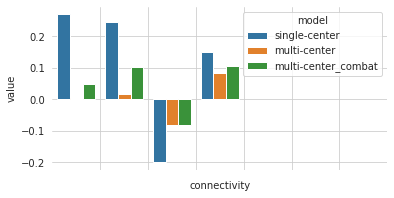

In [55]:
colors = ["tab:blue", "tab:orange", "tab:green"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

plt.figure(figsize=(6, 3))
sns.barplot(data=intersection_melt, x='connectivity', y='value', hue='model')
plt.xticks(rotation=80)
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.xticks([x-0.5 for x in range(1,8, 1)] )
plt.savefig('../res/multi-center/3_barplot.pdf')  

## Plot venn-diagrams

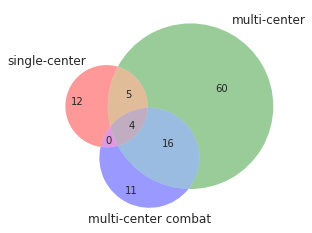

In [56]:
from matplotlib_venn import venn3

n_rpn = len(rpn_conns)
n_mc = len(multi_center_conns)
n_mccombat = len(multi_center_conns_combat)

n_intersection_rpn_mc = len(allconns[['single-center', 'multi-center']].dropna())
n_intersection_rpn_mccombat = len(allconns[['single-center', 'multi-center_combat']].dropna())
n_intersection_mc_mccombat = len(allconns[['multi-center', 'multi-center_combat']].dropna())

n_intersection_all = len(allconns[['single-center', 'multi-center', 'multi-center_combat']].dropna())




# Use the venn3 function
v=venn3(subsets = (n_rpn - n_intersection_rpn_mc - n_intersection_rpn_mccombat + n_intersection_all,    #Abc
                    n_mc - n_intersection_rpn_mc - n_intersection_mc_mccombat + n_intersection_all,    #aBc
                    n_intersection_rpn_mc - n_intersection_all,    #ABc
                    n_mccombat - n_intersection_rpn_mccombat - n_intersection_mc_mccombat +  n_intersection_all,    #abC
                    n_intersection_rpn_mccombat - n_intersection_all,    #AbC
                    n_intersection_mc_mccombat - n_intersection_all,    #aBC
                    n_intersection_all),          #ABC
        
                set_labels = ('single-center', 'multi-center', 'multi-center combat'))
#v.get_patch_by_id('10').set_color('tab:blue')
#v.get_patch_by_id('01').set_color('tab:orange')
#v.get_patch_by_id('11').set_color('tab:olive')
#v.get_patch_by_id('10').set_edgecolor('none')
#v.get_patch_by_id('01').set_edgecolor('none')
#v.get_patch_by_id('11').set_edgecolor('none')
#v.get_patch_by_id('10').set_alpha(0.5)
#v.get_patch_by_id('01').set_alpha(0.5)
plt.savefig('../res/multi-center/3_venn_num_conns.pdf')  

In [57]:
allconns[['connectivity', 'single-center', 'multi-center']].dropna()

,connectivity,single-center,multi-center
0,PUT_p - STgyr_p,0.270232,0.002417
1,CER5 - FP,0.245274,0.017253
2,CER6_p - PSMcor_p,-0.200617,-0.082088
3,R_CERCR2_a - MOTnet_l,0.149634,0.082394
4,MOTnet_m - MVISnet_p,-0.102468,-0.006288
9,COLsul - MOTnet_vl,-0.062491,-0.043420
12,CER6_d - OCCTgyr_l,-0.056635,-0.046375
14,R_IPsul - LVISnet_p,-0.053913,-0.002981
15,AINS_v - MVISnet_ad,-0.044237,-0.083777


In [58]:
allconns[['connectivity', 'single-center', 'multi-center_combat']].dropna()

,connectivity,single-center,multi-center_combat
0,PUT_p - STgyr_p,0.270232,0.047596
1,CER5 - FP,0.245274,0.103640
2,CER6_p - PSMcor_p,-0.200617,-0.080330
3,R_CERCR2_a - MOTnet_l,0.149634,0.104155


## Create large-scale network level summaries

In [59]:
module_names = np.unique(mod)
# creeate modular matrix:
rpn_matrix_pos = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)
rpn_matrix_neg = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)

conns_rpn=pd.DataFrame(columns=['reg_A', 'reg_B', 'mod_A', 'mod_B', 'weight'])

for i in range(len(rpn_conns)):
    if rpn_conns['weight'][i] > 0:
        rpn_matrix_pos.loc[rpn_conns.mod_A[i], rpn_conns.mod_B[i]] += rpn_conns['weight'][i]
        rpn_matrix_pos.loc[rpn_conns.mod_B[i], rpn_conns.mod_A[i]] += rpn_conns['weight'][i]

        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'mod_A'] = rpn_conns.mod_A[i]
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'mod_B'] = rpn_conns.mod_B[i]
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'reg_A'] = rpn_conns.mod_A[i] + '_pos'
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'reg_B'] = rpn_conns.mod_B[i] + '_pos'
        
        if np.isnan(conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'weight']):
            conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'weight'] = rpn_conns['weight'][i]
        else:
            conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_pos', 'weight'] += rpn_conns['weight'][i]
        
    if rpn_conns['weight'][i] < 0:
        rpn_matrix_neg.loc[rpn_conns.mod_A[i], rpn_conns.mod_B[i]] += rpn_conns['weight'][i]
        rpn_matrix_neg.loc[rpn_conns.mod_B[i], rpn_conns.mod_A[i]] += rpn_conns['weight'][i]
    
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'mod_A'] = rpn_conns.mod_A[i]
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'mod_B'] = rpn_conns.mod_B[i]
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'reg_A'] = rpn_conns.mod_A[i] + '_neg'
        conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'reg_B'] = rpn_conns.mod_B[i] + '_neg'
        if np.isnan(conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'weight']):
            conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'weight'] = rpn_conns['weight'][i]
        else:
            conns_rpn.loc[rpn_conns.mod_A[i] + rpn_conns.mod_B[i] + '_neg', 'weight'] += rpn_conns['weight'][i]

conns_rpn.to_csv('../res/multi-center/large-scale_conns_rpn.csv')

In [60]:
module_names = np.unique(mod)
# creeate modular matrix:
mc_matrix_pos = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)
mc_matrix_neg = pd.DataFrame(data=np.zeros((len(module_names), len(module_names))), columns=module_names, index=module_names)

conns_mc=pd.DataFrame(columns=['reg_A', 'reg_B','mod_A', 'mod_B', 'weight'])

for i in range(len(multi_center_conns)):
    if multi_center_conns['multi-center'][i] > 0:
        mc_matrix_pos.loc[multi_center_conns.mod_A[i], multi_center_conns.mod_B[i]] += multi_center_conns['multi-center'][i]
        mc_matrix_pos.loc[multi_center_conns.mod_B[i], multi_center_conns.mod_A[i]] += multi_center_conns['multi-center'][i]

        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'mod_A'] = multi_center_conns.mod_A[i]
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'mod_B'] = multi_center_conns.mod_B[i]
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'reg_A'] = multi_center_conns.mod_A[i] + '_pos'
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'reg_B'] = multi_center_conns.mod_B[i] + '_pos'
        
        if np.isnan(conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'weight']):
            conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'weight'] = multi_center_conns['multi-center'][i]
        else:
            conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_pos', 'weight'] += multi_center_conns['multi-center'][i]
        
    if multi_center_conns['multi-center'][i] < 0:
        mc_matrix_neg.loc[multi_center_conns.mod_A[i], multi_center_conns.mod_B[i]] += multi_center_conns['multi-center'][i]
        mc_matrix_neg.loc[multi_center_conns.mod_B[i], multi_center_conns.mod_A[i]] += multi_center_conns['multi-center'][i]
    
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'mod_A'] = multi_center_conns.mod_A[i]
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'mod_B'] = multi_center_conns.mod_B[i]
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'reg_A'] = multi_center_conns.mod_A[i] + '_neg'
        conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'reg_B'] = multi_center_conns.mod_B[i] + '_neg'
        if np.isnan(conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'weight']):
            conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'weight'] = multi_center_conns['multi-center'][i]
        else:
            conns_mc.loc[multi_center_conns.mod_A[i] + multi_center_conns.mod_B[i] + '_neg', 'weight'] += multi_center_conns['multi-center'][i]
        
conns_mc.to_csv('../res/multi-center/large-scale_conns_multi-center.csv')     

## Plot them as matrices

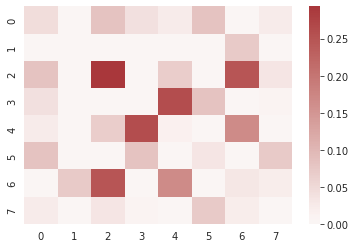

In [61]:
sns.heatmap(mc_matrix_pos.values, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_mc_pos.pdf')  

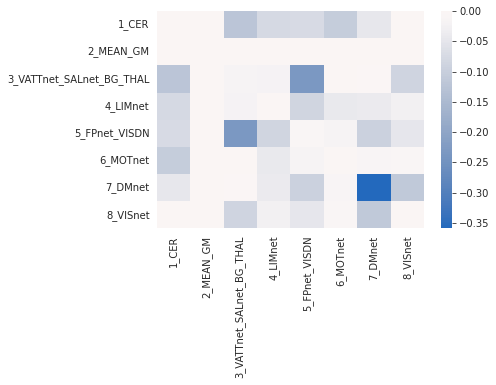

In [62]:
sns.heatmap(mc_matrix_neg, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_mc_neg.pdf')  

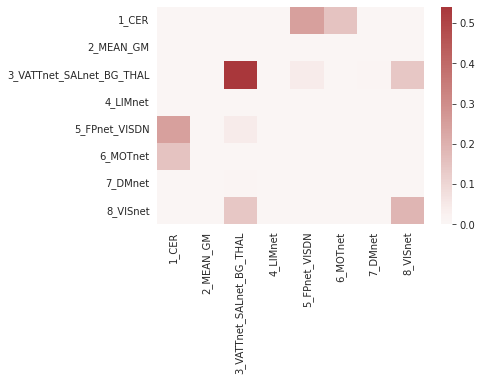

In [63]:
sns.heatmap(rpn_matrix_pos, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_rpn_pos.pdf')  

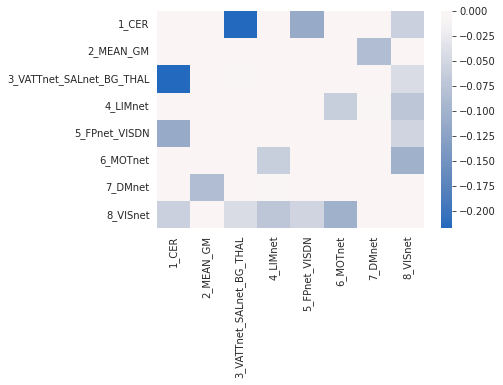

In [64]:
sns.heatmap(rpn_matrix_neg, cmap="vlag", center=0)
plt.savefig('../res/multi-center/mat_rpn_neg.pdf')  

## plot summed negative and positive contributions of large-scale networks

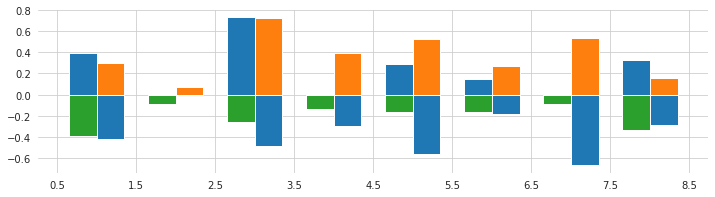

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 3)
x=np.array([1,2,3,4,5,6,7,8])
width=0.35
bar1pos=ax.bar(x - width/2, rpn_matrix_pos.sum(), width, label='single-center')
bar2pos=ax.bar(x + width/2, mc_matrix_pos.sum(), width, label='multi-center')

bar1neg=ax.bar(x - width/2, rpn_matrix_neg.sum(), width, label='single-center')
bar2neg=ax.bar(x + width/2, mc_matrix_neg.sum(), width, label='multi-center')
plt.grid(True)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.xticks([x-0.5 for x in range(1,10, 1)] )
plt.savefig('../res/multi-center/barplot_reg.pdf') 

## Display all connectivities

In [66]:
pd.set_option("display.max_rows", None)
allconns

,idx_A,idx_B,mod_A,mod_B,reg_A,reg_B,weight,abs_weight,single-center,connectivity,multi-center,abs_multi-center,multi-center_combat,abs_multi-center_combat
0,88,95,3_VATTnet_SALnet_BG_THAL,3_VATTnet_SALnet_BG_THAL,PUT_p,STgyr_p,0.270232,0.270232,0.270232,PUT_p - STgyr_p,0.002417,0.002417,0.047596,0.047596
1,15,45,1_CER,5_FPnet_VISDN,CER5,FP,0.245274,0.245274,0.245274,CER5 - FP,0.017253,0.017253,0.103640,0.103640
2,1,99,1_CER,3_VATTnet_SALnet_BG_THAL,CER6_p,PSMcor_p,-0.200617,0.200617,-0.200617,CER6_p - PSMcor_p,-0.082088,0.082088,-0.080330,0.080330
3,16,85,1_CER,6_MOTnet,R_CERCR2_a,MOTnet_l,0.149634,0.149634,0.149634,R_CERCR2_a - MOTnet_l,0.082394,0.082394,0.104155,0.104155
4,82,114,6_MOTnet,8_VISnet,MOTnet_m,MVISnet_p,-0.102468,0.102468,-0.102468,MOTnet_m - MVISnet_p,-0.006288,0.006288,NaN,NaN
5,121,122,8_VISnet,8_VISnet,LVISnet_DP,VVISnet_m,0.094911,0.094911,0.094911,LVISnet_DP - VVISnet_m,NaN,NaN,NaN,NaN
6,0,34,2_MEAN_GM,7_DMnet,aMEAN_GM,L_IPlob,-0.086423,0.086423,-0.086423,aMEAN_GM - L_IPlob,NaN,NaN,NaN,NaN
7,96,116,3_VATTnet_SALnet_BG_THAL,8_VISnet,CAUDN_v,LVISnet_p,0.085078,0.085078,0.085078,CAUDN_v - LVISnet_p,NaN,NaN,NaN,NaN
8,67,118,4_LIMnet,8_VISnet,CAUDNH_NACC,PVISnet_vm,-0.072571,0.072571,-0.072571,CAUDNH_NACC - PVISnet_vm,NaN,NaN,NaN,NaN
9,68,84,4_LIMnet,6_MOTnet,COLsul,MOTnet_vl,-0.062491,0.062491,-0.062491,COLsul - MOTnet_vl,-0.043420,0.043420,NaN,NaN


### multi-center only

'L_MFgyr_a - LORBgyr', 'POsul_v - R_PORB', 'DMPFcor_ac - CAUDN_d', 'DMPFC_ar - R_MTgyr_p', 'R_MFgyr_a - PUT_p', 'THAL_v - PINS_d', 'L_ANGgyr - LVISnet_vp', 'CER6_d - MOTnet_m', 'FUSgyr_dl - AMY'

### single center only
'LVISnet_DP - VVISnet_m', 'aMEAN_GM - L_IPlob', 'CAUDN_v - LVISnet_p', 'CAUDNH_NACC - PVISnet_vm', 'CER5 - LVISnet_DP', 'THAL_v - LVISnet_p', 'CER9_d - L_IFsul', 'R_MFgyr_a - l_PCsul', 'CERCR1 - PCsul_d'

### overlap
'PUT_p - STgyr_p', 'CER5 - FP', 'CER6_p - PSMcor_p','R_CERCR2_a - MOTnet_l','MOTnet_m - MVISnet_p','COLsul - MOTnet_vl','CER6_d - OCCTgyr_l','R_IPsul - LVISnet_p','AINS_v - MVISnet_ad'


## Save finalized multi-center connections

In [67]:
multi_center_conns.to_csv('../res/multi-center/finalized_model_connections.csv')

# predictive connections per center

In [68]:
from sklearn import preprocessing
X = joblib.load('../res/multi-center/all_features.joblib')
X = preprocessing.RobustScaler().fit_transform(X)

RES = np.zeros(int(len(labels)*(len(labels)-1)/2))

featuremask = model_multi_center.named_steps['fsel'].get_support()
RES[featuremask] = model_multi_center.named_steps['model'].coef_

*** L_MFgyr_a - LORBgyr study 1 [0.16331956] [nan] ****************************************************
R=0.11
p_corr=0.25622
*** L_MFgyr_a - LORBgyr study 2 [0.16331956] [nan] ****************************************************
R=0.43
p_corr=0.00412
*** L_MFgyr_a - LORBgyr study 3 [0.16331956] [nan] ****************************************************
R=0.11
p_corr=0.33671
*** POsul_v - R_PORB study 1 [0.14046068] [nan] ****************************************************
R=0.45
p_corr=0.00325
*** POsul_v - R_PORB study 2 [0.14046068] [nan] ****************************************************
R=0.26
p_corr=0.05562
*** POsul_v - R_PORB study 3 [0.14046068] [nan] ****************************************************
R=0.29
p_corr=0.11861
*** DMPFcor_ac - CAUDN_d study 1 [0.13891801] [nan] ****************************************************
R=0.25
p_corr=0.06837
*** DMPFcor_ac - CAUDN_d study 2 [0.13891801] [nan] ****************************************************
R=0.45
p_corr=0.00187

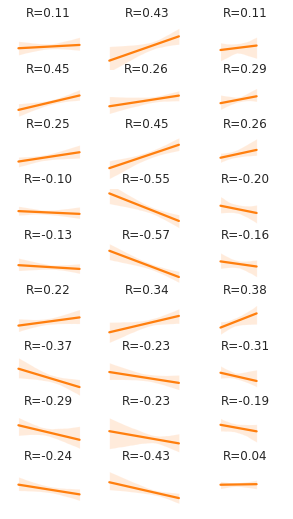

In [69]:
# multi-center-only
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values
    #"study 1+2+3" : np.array([True] * len(y))
}

from mlxtend.evaluate import permutation_test

conns = ['L_MFgyr_a - LORBgyr', 'POsul_v - R_PORB', 'DMPFcor_ac - CAUDN_d', 'DMPFC_ar - R_MTgyr_p', 'R_MFgyr_a - PUT_p', 'THAL_v - PINS_d', 'L_ANGgyr - LVISnet_vp', 'CER6_d - MOTnet_m', 'FUSgyr_dl - AMY']

fig, axs = plt.subplots(ncols=3, nrows=len(conns), figsize=(5,1*len(conns)), sharex=True, sharey=True)

#cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(conns):
    for col, study in enumerate(study_masks.keys()):
        
        coef = allconns[allconns.connectivity==cv]['multi-center'].values
        coef_sc = allconns[allconns.connectivity==cv]['single-center'].values
        idx=np.argwhere(RES==coef).flatten()
        
        g=sns.regplot(x=y[study_masks[study]].values, y=X[:,idx].flatten()[study_masks[study]], ax=axs[row, col],
                    scatter=False, scatter_kws={'alpha':0.3}, color='tab:orange')
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-2, 2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        #axs[row, col].grid(True) 
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])
        
        print('***', cv, study, coef, coef_sc, '****************************************************')
                   
        corr = np.corrcoef(X[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values)[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(X[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
   
        
plt.savefig('../res/multi-center/regplots_obs_conn_mc_nocombat.pdf')  

*** PUT_p - STgyr_p study 1 [0.00241732] [0.2702318] [4553] ****************************************************
R=0.58
p_corr=0.00025
*** PUT_p - STgyr_p study 2 [0.00241732] [0.2702318] [4553] ****************************************************
R=0.28
p_corr=0.04637
*** PUT_p - STgyr_p study 3 [0.00241732] [0.2702318] [4553] ****************************************************
R=-0.09
p_corr=0.63767
*** CER5 - FP study 1 [0.01725328] [0.24527389] [1005] ****************************************************
R=0.57
p_corr=0.00037
*** CER5 - FP study 2 [0.01725328] [0.24527389] [1005] ****************************************************
R=0.31
p_corr=0.03037
*** CER5 - FP study 3 [0.01725328] [0.24527389] [1005] ****************************************************
R=0.26
p_corr=0.13298
*** CER6_p - PSMcor_p study 1 [-0.08208786] [-0.20061663] [4852] ****************************************************
R=-0.49
p_corr=0.99875
*** CER6_p - PSMcor_p study 2 [-0.08208786] [-0.20061663] [4852

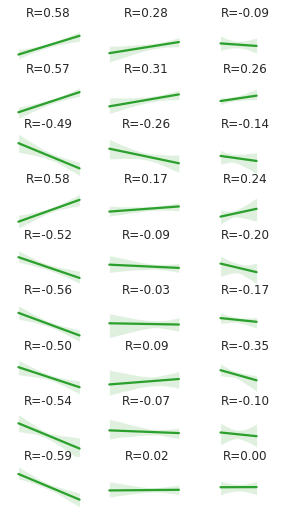

In [70]:
# overlap
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values
    #"study 1+2+3" : np.array([True] * len(y))
}

from mlxtend.evaluate import permutation_test

conns = ['PUT_p - STgyr_p', 'CER5 - FP', 'CER6_p - PSMcor_p','R_CERCR2_a - MOTnet_l','MOTnet_m - MVISnet_p','COLsul - MOTnet_vl','CER6_d - OCCTgyr_l','R_IPsul - LVISnet_p','AINS_v - MVISnet_ad']

fig, axs = plt.subplots(ncols=3, nrows=len(conns), figsize=(5,1*len(conns)), sharex=True, sharey=True)

#cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(conns):
    for col, study in enumerate(study_masks.keys()):
        
        coef = allconns[allconns.connectivity==cv]['multi-center'].values
        coef_sc = allconns[allconns.connectivity==cv]['single-center'].values
        idx=np.argwhere(RES==coef).flatten()
        
        print('***', cv, study, coef, coef_sc, idx, '****************************************************')
        
        g=sns.regplot(x=y[study_masks[study]].values, y=X[:,idx].flatten()[study_masks[study]], ax=axs[row, col],
                    scatter=False, scatter_kws={'alpha':0.3}, color='tab:green')
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-2, 2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        #axs[row, col].grid(True) 
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])
                        
        corr = np.corrcoef(X[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values)[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(X[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
   
        
plt.savefig('../res/multi-center/regplots_obs_conn_overlap_nocombat.pdf')  

['LVISnet_DP', 'VVISnet_m']
*** LVISnet_DP - VVISnet_m study 1 [nan] [0.09491079] [[7502]] ****************************************************
R=0.52
p_corr=0.00125
['LVISnet_DP', 'VVISnet_m']
*** LVISnet_DP - VVISnet_m study 2 [nan] [0.09491079] [[7502]] ****************************************************
R=-0.13
p_corr=0.78115
['LVISnet_DP', 'VVISnet_m']
*** LVISnet_DP - VVISnet_m study 3 [nan] [0.09491079] [[7502]] ****************************************************
R=-0.05
p_corr=0.56505
['GlobSig', 'L_IPlob']
*** GlobSig - L_IPlob study 1 [] [] [[406]] ****************************************************
R=-0.17
p_corr=0.83065
['GlobSig', 'L_IPlob']
*** GlobSig - L_IPlob study 2 [] [] [[406]] ****************************************************
R=-0.19
p_corr=0.87477
['GlobSig', 'L_IPlob']
*** GlobSig - L_IPlob study 3 [] [] [[406]] ****************************************************
R=-0.04
p_corr=0.55918
['CAUDN_v', 'LVISnet_p']
*** CAUDN_v - LVISnet_p study 1 [nan] [0.08507

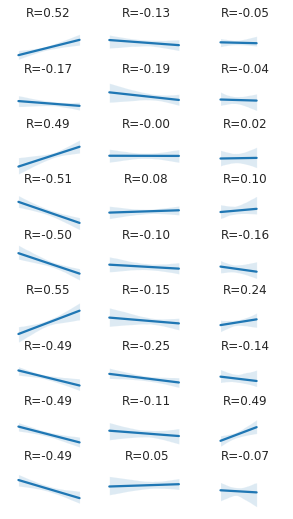

In [71]:
# overlap
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values
    #"study 1+2+3" : np.array([True] * len(y))
}

from mlxtend.evaluate import permutation_test

conns = ['LVISnet_DP - VVISnet_m', 'GlobSig - L_IPlob', 'CAUDN_v - LVISnet_p', 'CAUDNH_NACC - PVISnet_vm', 'CER5 - LVISnet_DP', 'THAL_v - LVISnet_p', 'CER9_d - L_IFsul', 'R_MFgyr_a - l_PCsul', 'CERCR1 - PCsul_d']

fig, axs = plt.subplots(ncols=3, nrows=len(conns), figsize=(5,1*len(conns)), sharex=True, sharey=True)

#cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(conns):
    for col, study in enumerate(study_masks.keys()):
        
        coef = allconns[allconns.connectivity==cv]['multi-center'].values
        coef_sc = allconns[allconns.connectivity==cv]['single-center'].values
        
        EX_MAT = pd.DataFrame(vec_to_sym_matrix(np.zeros(int(len(labels)*(len(labels)-1)/2)),
                                        diagonal=np.repeat(0, len(labels))),
                      columns=labels, index=labels)
        regs = cv.split(' - ')
        EX_MAT.loc[regs[0], regs[1]] = EX_MAT.loc[regs[1], regs[0]] = 1
        print(regs)
        EX_MAT.loc[regs[0], regs[1]] = EX_MAT.loc[regs[1], regs[0]] = 1
        vec_mask = sym_matrix_to_vec(EX_MAT.values, discard_diagonal=True)
        idx=np.argwhere(vec_mask==1)
        
        print('***', cv, study, coef, coef_sc, idx, '****************************************************')
        
        g=sns.regplot(x=y[study_masks[study]].values, y=X[:,idx].flatten()[study_masks[study]], ax=axs[row, col],
                    scatter=False, scatter_kws={'alpha':0.3}, color='tab:blue')
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-2, 2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        #axs[row, col].grid(True) 
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])
                        
        corr = np.corrcoef(X[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values)[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(X[:,idx].flatten()[study_masks[study]], y[study_masks[study]].values,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
   
        
plt.savefig('../res/multi-center/regplots_obs_conn_sc_nocombat.pdf')